# 1. Creating different geodynamical experiments:

This notebook aims to create different examples of geodymanical experiments as:

- Lithosphere Asthenosphere Boundary (LAB) stability over time to test Dynamic Equilibrium over hundreds of Myrs

- Continental rifting

- Wilson cycle - Rifting followed by inversion of the velocity field to emulate continental colision

- Evolution of a cratonic keel over hundreds of Myrs

By choosing one of the experiments above, the following script will automatically create the correct interfaces and boundary conditions to simulate each geodynamic experiment above.

We also implement some strategies to use the final thermal state from a given previous stability experiment as initial temperature field for other experiments.

The domain of the model comprises `Lx` x `Lz` km<sup>2</sup>, composed of a regular mesh with square elements with `Nx` x `Nz` points chosen by the user.

For Rifting and Wilson Cycle experiments, the boundary conditions for the velocity field simulate the lithospheric stretching 
assuming a reference frame fixed on the lithospheric plate on the left side of the model,
and the plate on the right side moves rightward with a `velocity` chosen by the User in cm/year.

The velocity field in the left and right boundaries of the model is chosen to ensure conservation of mass
and is symmetrical if the adopted reference frame movies to the right with a velocity of 0.5 cm/year relative to the left plate.
Additionally, free slip condition was assumed on the top and bottom of the numerical domain.

To simulate the free surface, the "sticky air" approach (e.g. Gerya and Yuen, 2003b) is adopted,
taking into account a 40-km thick layer with a relatively low viscosity material but with a compatible density with the atmospheric air.
The initial temperature structure is only depth dependent and is 0 ºC at the surface and 1300 ºC at the base of the lithosphere at 130 km.

To avoid artifacts created by a homogeneous rheology, a random perturbation of the initial strain in each finite element of the model (e.g. Brune et al., 2014) is applied.
This random perturbation follows a normal distribution in which the mean initial strain is 0.25 with a standard deviation of 0.08.
Additionally, to ensure the nucleation of rifting at the center of the numerical domain,
a weak seed (e.g. Huismans and Beaumont, 2003) is present in the lithospheric mantle with a constant initial strain of 0.3.

# 2. Importing libraries and defining functions

In [7]:
import os
import glob
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.interpolate import interp2d

label_size=18
plt.rc('xtick', labelsize=label_size)
plt.rc('ytick', labelsize=label_size)

#CLASSES
class MandyocLayer:
    def __init__(self, layer_label, rheology: type,
                 density, effective_viscosity_scale_factor=1.0, radiogenic_heat_production=0.0,
                 base_depth=0.0e3, Nx=None):
        """"
        This class creates a layer with the given properties
        layer_label: str
            Name of the layer
        rheology: class
            Rheological properties of the layer onbtained from LithologicalUnit class
        density: float
            Density of the layer [kg/m3]
        interface: NoneType or np.array
            Interface of the layer.
            If None, the interface will be setted after the creation of the Layer.
            If np.array, the interface is defined by the given array.
        effective_viscosity_scale_factor: float
            Scale factor for the effective vistocisty
        radiogenic_heat_production: float
            Radiogenic heat production of the layer [W/kg]
        base_depth: float
            Depth of the layer base [m]
        Nx: int
            Number of points in x direction
        """

        self.layer_label = layer_label
        self.rheology = LithologicalUnit(rheology)
        self.density = density
        self.effective_viscosity_scale_factor = effective_viscosity_scale_factor
        self.radiogenic_heat_production = radiogenic_heat_production
        self.rheology_name = self.rheology.name
        self.pre_exponential_constant = self.rheology.pre_exponential_constant
        self.power_law_exponent = self.rheology.power_law_exponent
        self.activation_energy = self.rheology.activation_energy
        self.activation_volume = self.rheology.activation_volume
        self.base_depth = base_depth
        self.Nx = Nx

        self.interface = np.ones(Nx)*base_depth

class LithologicalUnit:
    """"
    This class calls the respective rheological properties of the given mineral

    mineral_name: class
        Mineral rheology written in CamelCase. For example, WetOlivine, DryOlivine, WetQuartz
    """
    def __init__(self, mineral_name: type):
        self.mineral_name = mineral_name() # mineral_name is a class, so we need to call it to get the object
        self.name = self.mineral_name.name
        self.pre_exponential_constant = self.mineral_name.pre_exponential_constant
        self.power_law_exponent = self.mineral_name.power_law_exponent
        self.activation_energy = self.mineral_name.activation_energy
        self.activation_volume = self.mineral_name.activation_volume

class WetOlivine:
    """
    Wet olivine rheological properties
    """
    def __init__(self):
        self.name = 'wet_olivine'
        self.pre_exponential_constant = 1.393e-14
        self.power_law_exponent = 3
        self.activation_energy = 429.0e3
        self.activation_volume = 15.0e-6

class DryOlivine:
    """
    Dry olivine rheological properties
    """
    def __init__(self):
        self.name = 'dry_olivine'
        self.pre_exponential_constant = 2.4168e-15
        self.power_law_exponent = 3.5
        self.activation_energy = 540.0e3
        self.activation_volume = 25.0e-6

class WetQuartz:
    """
    Wet quartz rheological properties
    """
    def __init__(self):
        self.name = 'wet_quartz'
        self.pre_exponential_constant = 8.574e-28
        self.power_law_exponent = 4.0
        self.activation_energy = 222.0e3
        self.activation_volume = 0.0

class Air:
    """
    Air rheological properties
    """
    def __init__(self):
        self.name = 'air'
        self.pre_exponential_constant = 1.0e-18
        self.power_law_exponent = 1.0
        self.activation_energy = 0.0
        self.activation_volume = 0.0
    

#FUNCTIONS
def find_nearest(array, value):
    '''Return the index in array nearest to a given value.
    
    Parameters
    ----------
    
    array: array_like
        1D array used to find the index
        
    value: float
        Value to be seached
    '''
    
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def read_params(fpath):
    '''
    Read param.txt and returns Nx, Nz, Lx, Lz of the scenario givem by fpath
    
    Parameters
    ----------
    
    fpath: str
        Path to the param.txt file
    '''
    with open(fpath+"param.txt","r") as f:
        line = f.readline()
        line = line.split() #split by space a string to a list of strings
        Nx = int(line[-1])
        
        line = f.readline()
        line = line.split()
        Nz = int(line[-1])

        line = f.readline()
        line = line.split()
        Lx = float(line[-1])

        line = f.readline()
        line = line.split()
        Lz = float(line[-1])

    return Nx, Nz, Lx, Lz

def read_data(prop, step, Nz, Nx, fpath):
    '''
    Read and reshape readed data according to parameters to return a (Nx, Nz) array.
    
    Parameters
    ----------
    
    prop: str
        Property of the mandyoc outputs: temperature, density, strain, strain_rate, viscosity, heat or pressure.
        
    step: str
        Time step of numerical scenario.
        
    Nz: int
        Number of points in z direction.
        
    Nx: int
        Number of points in x direction.
        
    fpath: str
        Path to the param.txt file.
    '''
    
    #build filename
    filename = fpath + prop + "_" + str(step) + ".txt"

    data = np.loadtxt(filename, skiprows=2, unpack=True, comments="P")
    data = np.reshape(data, (Nz, Nx))
    
    return data

def calc_mean_temperaure_region(data, Nz, xx, begin, end):
    '''
    This funcition select a region in x direction in a 2D array and calculates the horizontal mean

    Parameters
    ----------

    data: `numpy.ndarray`

    Nz: int
        Number of points in Z direction

    xx: numpy.ndarray
        2D grid with x cordinates

    begin: float
        Start point

    end: float
        End point

    Returns
    -------
    arr: `numpy.ndarray`
        Array containing the horizontal mean of selected region
    '''

    x_region = (xx >= begin) & (xx <= end)
    Nx_aux = len(x_region[0][x_region[0]==True])
    data_sel = data[x_region].reshape(Nz, Nx_aux)
    data_sel_mean = np.mean(data_sel, axis=1)
    
    return data_sel_mean

def Tp_estimate(mean_temp, z, zbot, ztop, h_air=40.0e3):
    zcond = (z<=zbot-h_air) & (z>=ztop-h_air) #considering air layer

    zcut = z[zcond]
    tcut = mean_temp[zcond]

    params = curve_fit(fit_func, zcut, tcut)
    [a, b] = params[0]

    tfit = a*z + b #temeprature fitted

    #find the mantle potential temperature
    idx = np.where(z == 40.0)[0][0] #air thickness = 40 
    Tp = int(np.round(tfit[idx], 0))

    return Tp, tfit

def fit_func(x, a, b):
    return a*x + b

# 3. Useful paths

Identifying operational system (Linux or MacOSX) and the path to the Preliminary Model, if needed.

In [8]:
path = os.getcwd().split('/')
machine_path = f'/{path[1]}/{path[2]}'
print(machine_path)

#Linux
# path_to_preliminary_model = '/home/joao_macedo/Doutorado/cenarios/mandyoc/stable/lit80km/stable_PT290_rheol19_c1250_C1_HprodAst/' #For cratonic experiment
# path_to_preliminary_model = '/home/joao_macedo/Doutorado/cenarios/mandyoc/stable/lit120km/STB_DT230oC_Hlit120km_Hast7e-12/' #For Rifting experiment
# path_to_preliminary_model = '/media/joao_macedo/Joao_Macedo/Doutorado/cenarios/mandyoc/stable/lit80km/stable_PT290_rheol19_c1250_C1_HprodAst/' #For cratonic experiment
# path_to_preliminary_model = '/media/joao_macedo/Joao_Macedo/Doutorado/cenarios/mandyoc/stable/lit120km/STB_DT230oC_Hlit120km_Hast7e-12/' #For Rifting experiment

#MacOS
# path_to_preliminary_model = '/Users/joao_macedo/Doutorado/cenarios/mandyoc/stable/lit80km/stable_PT290_rheol19_c1250_C1_HprodAst/' #For cratonic experiment
# path_to_preliminary_model = '/Users/joao_macedo/Doutorado/cenarios/mandyoc/stable/lit120km/STB_DT230oC_Hlit120km_Hast7e-12/' #For Rifting experiment
path_to_preliminary_model = '/Volumes/Joao_Macedo/Doutorado/cenarios/mandyoc/stable/lit80km/stable_PT290_rheol19_c1250_C1_HprodAst/' #For cratonic experiment
path_to_preliminary_model = '/Volumes/Joao_Macedo/Doutorado/cenarios/mandyoc/stable/lit120km/STB_DT230oC_Hlit120km_Hast7e-12/' #For Rifting experiment


/Users/joao_macedo


## 3. Define the type of the geodynamic experiment and number of CPU cores

Here we have four types of geodynamic experiments. You must choose between:

- `'stability'`: Lithosphere Asthenosphere Boundary (LAB) stability over time. This experiment aims to be used as Preliminary Experiment following the approach of Petersen et al. (2010) to achieve a dynamic equilibrium state.
- `'rifting'`: Rifting experiment (e.g.: Silva et al., 2023).
- `'wilson_cycle'`: Wilson cycle experiment starting from rifting to collision (e.g. Salazar-Mora et al., 2018).
- `'cratonic_keel'`: Evolution of a central cratonic keel over time based on Silva et al. (2025)


Select by uncommenting one of the `experiment` options in the cell below

Set the number of cores in `ncores`

In [9]:
# Geodynamic experiments
experiments = {'rifting': 'Rifting experiment',
               'stability': 'LAB (1300 oC) stability',
               'wilson_cycle': 'Wilson Cycle',
               'cratonic_keel': 'Cratonic Keel',
               }

#Uncomment one of the lines below to select the the kind of tectonic scenario
# experiment = 'rifting'
# experiment = 'stability'
# experiment = 'wilson_cycle'
experiment = 'cratonic_keel'

ncores=20

## 4. Setup the numerical scenario according to the selected numerical experiment

Some of parameters changes according to the selected type of experiment, e.g.:
- Temperature boundary conditions
- Velocity boundary conditions

Therefore, for each conditional (`if(experiment == <type_of_experiment>)`) below, we set the main parameters of the respective experiment.

The parameters are used to:
- Create the param.txt
- Determine if the user will use a Preliminary Model to create the inintal temperature file by setting the `preset` as `True`or `False`
- Increase of basal temperature if `preset = False`

In [10]:
#Main parameters used to construct param .txt that changes accordind to


####################################
#                                  #
#            Stability             #      
# (Used as Preliminary Experiment) #
#                                  #
####################################

if(experiment == 'stability'):
    # DeltaT = 0
    DeltaT = 200 #oC incrase in initial guess of mantle potential temperature
    # DeltaT = 350

    preset = False
    # keel_center = True

    keel_center = False
    extra_fragil = False

    # keel_adjust = True
    keel_adjust = False

    # high_kappa_in_asthenosphere = True
    high_kappa_in_asthenosphere = False #default
    
    #Convergence criteria
    # denok = 1.0e-11
    # denok = 1.0e-13
    denok = 1.0e-12

    # dt_max = 5.0e3 #default
    dt_max = 2.0e3
    # dt_max = 2.5e3

    particles_per_element = 100
    
    #Surface constrains
    sp_surface_tracking = True
    sp_surface_processes = False
    
    #time constrains  
    time_max = 1.0e9 
    step_print = 500
    
    #External inputs: bc velocity, velocity field, precipitation and
    #climate change
    variable_bcv = False
    velocity_from_ascii = False
    
    
    if(sp_surface_processes == True):
        precipitation_profile_from_ascii = True #False
        climate_change_from_ascii = True #False
    else:
        precipitation_profile_from_ascii = False
        climate_change_from_ascii = False

    
    #step files
    print_step_files = True
    
    # checkered = False
    checkered = True

    #velocity bc
    top_normal_velocity                 = 'fixed'         # ok
    top_tangential_velocity             = 'free '         # ok
    bot_normal_velocity                 = 'fixed'         # ok
    bot_tangential_velocity             = 'free '         # ok
    left_normal_velocity                = 'fixed'         # ok
    left_tangential_velocity            = 'free '         # ok
    right_normal_velocity               = 'fixed'         # ok
    right_tangential_velocity           = 'free'         # ok

    # periodic_boundary = True
    periodic_boundary = False
    
    if(periodic_boundary == True):
        left_normal_velocity            = 'free'         # ok
        left_tangential_velocity        = 'free'         # ok
        right_normal_velocity           = 'free'         # ok
        right_tangential_velocity       = 'free'         # ok

    #temperature bc
    top_temperature                     = 'fixed'         # ok
    bot_temperature                     = 'fixed'         # ok
    left_temperature                    = 'free'          # ok
    right_temperature                   = 'free'          # ok

    ##################################################################
    # total model horizontal extent (m)
    Lx = 1600 * 1.0e3
    # total model vertical extent (m)
    Lz = 700 * 1.0e3 #400 * 1.0e3
    # number of points in horizontal direction
    Nx = 161 #401 # #801 #1601
    # number of points in vertical direction
    Nz = 71 #176 #71 #176 #351 #71 #301 #401

    seed_in_litho = False

####################################
#                                  #
#             Rifting              #
#                                  #
####################################

elif(experiment == 'rifting'):
    ###########################################################################################
    # In case of using the final thermal state of a preliminary stability experiment instead  #
    # the default temperature field, set `preset = True` and give the path to the Preliminary #
    # Experiment `scenario` variable                                                          #
    ###########################################################################################

    # Increment in the basal temperature of initial thermal porfile
    DeltaT = 0
    # DeltaT = 290 # oC

    # preset = True
    preset = False
    
    partial_path_to_preliminary_model = '/Doutorado/cenarios/mandyoc/stable/lit120km/STB_DT230oC_Hlit120km_Hast7e-12/'
    # partial_path_to_preliminary_model = '/Doutorado/cenarios/mandyoc/stable/lit120km/STB_DT370oC_Hlit120km_Hast7e-12/'

    # selection_in_preset = True
    selection_in_preset = False

    # keel_adjust = True
    keel_adjust = False

    # keel_center = True
    keel_center = False

    # extra_fragil = True
    extra_fragil = False

    # mean_litho = True
    mean_litho = False

    # high_kappa_in_asthenosphere = True
    high_kappa_in_asthenosphere = False #default

    #Convergence criteria
    denok = 1.0e-15
    particles_per_element = 100

    #Surface constrains
    sp_surface_tracking = True
    sp_surface_processes = False
    # sp_surface_processes = True
    
    #time constrains 
    time_max = 40.0e6
    dt_max = 5.0e3
    # time_max = 200.0e6
    step_print = 100

    #External inputs: bc velocity, velocity field, precipitation and
    #climate change

    #############################################
    # Choose the velocity of the velocity field #
    #############################################

    # velocity = 0.5 #cm/yr
    velocity = 1.0 #cm/yr
    # velocity = 2.0 #cm/yr

    variable_bcv = False
    velocity_from_ascii = True
    ast_wind = False #Dafault. ast wind is used only in cratonic keel experiments

    if(sp_surface_processes == True):
        precipitation_profile_from_ascii = True #False
        climate_change_from_ascii = True #False
    else:
        precipitation_profile_from_ascii = False
        climate_change_from_ascii = False

    ####################################################################
    # step files are used to print information of Lagrangian particles #
    ####################################################################
    print_step_files = True
    checkered = False
    # checkered = True   

    #velocity bc
    top_normal_velocity                 = 'fixed'         # ok
    top_tangential_velocity             = 'free '         # ok
    bot_normal_velocity                 = 'fixed'         # ok
    bot_tangential_velocity             = 'free '         # ok
    left_normal_velocity                = 'fixed'         # ok
    left_tangential_velocity            = 'free '         # ok
    right_normal_velocity               = 'fixed'         # ok
    right_tangential_velocity           = 'fixed'         # ok

    # periodic_boundary = True
    periodic_boundary = False
    if(periodic_boundary == True):
        left_normal_velocity            = 'free'         # ok
        left_tangential_velocity        = 'free '         # ok
        right_normal_velocity           = 'free'         # ok
        right_tangential_velocity       = 'free'         # ok

    #temperature bc
    top_temperature                     = 'fixed'         # ok
    bot_temperature                     = 'fixed'         # ok
    left_temperature                    = 'fixed'          # ok
    right_temperature                   = 'fixed'          # ok

    ##################################################################
    # total model horizontal extent (m)
    Lx = 1000 * 1.0e3
    # total model vertical extent (m)
    Lz = 300 * 1.0e3 #400 * 1.0e3
    # Lz = 440 * 1.0e3
    # number of points in horizontal direction
    # Nx = 501 #
    # Nx = 801
    Nx = 1001
    # number of points in vertical direction
    # Nz = 151  #
    # Nz = 111 #Belon
    # Nz = 351
    Nz = 301

    seed_in_litho = True
    
####################################
#                                  #
#         Wilson cycle             #
#                                  #
####################################

elif(experiment == 'wilson_cycle'):    
    ###########################################################################################
    # In case of using the final thermal state of a preliminary stability experiment instead  #
    # the default temperature field, set `preset = True` and give the path to the Preliminary #
    # Experiment `scenario` variable                                                          #
    ###########################################################################################

    #increase in asthenospheric thermal profile
    DeltaT = 0
    # DeltaT = 290 # oC
    
    # preset = True
    preset = False
    
    partial_path_to_preliminary_model = '/Doutorado/cenarios/mandyoc/stable/lit120km/STB_DT230oC_Hlit120km_Hast7e-12/'

    # keel_center = True
    keel_center = False

    keel_adjust = False

    ast_wind = False

    selection_in_preset = False
    # selection_in_preset = True

    # extra_fragil = True
    extra_fragil = False

    # mean_litho = True
    mean_litho = False

    # high_kappa_in_asthenosphere = True
    high_kappa_in_asthenosphere = False #default

    #Convergence criteria
    denok                            = 1.0e-15
    particles_per_element            = 100

    #Surface constrains
    sp_surface_tracking              = True

    # sp_surface_processes             = True
    sp_surface_processes             = False

    #time constrains 
    time_max                         = 130.0e6
    dt_max                           = 5.0e3
    step_print                       = 100

    #External inputs: bc velocity, velocity field, precipitation and
    #climate change
    # velocity = 0.5 #cm/yr
    velocity = 1.0 #cm/yr
    # velocity = 2.0 #cm/yr

    variable_bcv                     = True
    velocity_from_ascii              = True

    if(sp_surface_processes == True):
        precipitation_profile_from_ascii = True #False
        climate_change_from_ascii        = True #False
    else:
        precipitation_profile_from_ascii = False
        climate_change_from_ascii        = False

    # 
    #step files
    print_step_files                 = True

    checkered = False
    # checkered = True

    #velocity bc
    top_normal_velocity                 = 'fixed'         # ok
    top_tangential_velocity             = 'free '         # ok
    bot_normal_velocity                 = 'fixed'         # ok
    bot_tangential_velocity             = 'free '         # ok
    left_normal_velocity                = 'fixed'         # ok
    left_tangential_velocity            = 'free '         # ok
    right_normal_velocity               = 'fixed'         # ok
    right_tangential_velocity           = 'fixed'         # ok

    # periodic_boundary = True
    periodic_boundary = False
    if(periodic_boundary == True):
        left_normal_velocity                = 'free'         # ok
        left_tangential_velocity            = 'free '         # ok
        right_normal_velocity               = 'free'         # ok
        right_tangential_velocity           = 'free'         # ok

    #temperature bc
    top_temperature                     = 'fixed'         # ok
    bot_temperature                     = 'fixed'         # ok
    left_temperature                    = 'fixed'          # ok
    right_temperature                   = 'fixed'          # ok

    ##################################################################
    # total model horizontal extent (m)
    Lx = 1000 * 1.0e3 #m
    # Lx = 1600 * 1.0e3
    
    # total model vertical extent (m)
    # Lz = 700 * 1.0e3 #400 * 1.0e3
    # Lz = 440 * 1.0e3
    Lz = 300 * 1.0e3

    # number of points in horizontal direction
    Nx = 501
    # Nx = 401 #
    # Nx = 801
    # Nx = 1001

    # number of points in vertical direction
    Nz = 151
    # Nz = 176  #
    # Nz = 351
    # Nz = 301

    seed_in_litho = True
    
#####################################
#                                   #
#          Cratonic Keel            #      
#                                   #
#####################################

elif(experiment == 'cratonic_keel'):
    ###########################################################################################
    # In case of using the final thermal state of a preliminary stability experiment instead  #
    # the default temperature field, set `preset = True` and give the path to the Preliminary #
    # Experiment `scenario` variable                                                          #
    ###########################################################################################
 
    DeltaT = 0
    # DeltaT = 200
    # DeltaT = 350

    # preset = True
    preset = False

    # selection_in_preset = True
    selection_in_preset = False

    # mobile_belt = False
    mobile_belt = True

    shift_craton = 0.0e3 #m
    # shift_craton = 700.0e3 #m

    shift_mb = 0.0e3 #m
    # shift_mb = 700.0e3 #m

    #Force cold cratonic keel
    keel_adjust = True
    # keel_adjust = False

    # keel_center = True
    keel_center = False

    # extra_fragil = True
    extra_fragil = False

    # mean_litho = True
    mean_litho = False

    # high_kappa_in_asthenosphere = True
    high_kappa_in_asthenosphere = False #default
    
    free_continent = False
    # free_continent = True

    # hot_surface = True
    hot_surface = False

    # seed = False
    # seed = True

    # partial_path_to_preliminary_model = '/Doutorado/cenarios/mandyoc/stable/lit80km/stable_PT200_rheol19_c1250_C1_HprodAst/'
    partial_path_to_preliminary_model = '/Doutorado/cenarios/mandyoc/stable/lit80km/stable_PT290_rheol19_c1250_C1_HprodAst/'
    # partial_path_to_preliminary_model = '/Doutorado/cenarios/mandyoc/stable/lit80km/stable_PT350_rheol19_c1250_C1_

    #Convergence criteria
    denok = 1.0e-11
    particles_per_element = 100
    
    #Surface constrains
    sp_surface_tracking = True
    sp_surface_processes = False

    #time constrains 
    time_max = 1.0e9
    dt_max = 5.0e3 #default
    step_print = 500    
    
    #External inputs: bc velocity, velocity field, precipitation and
    #climate change
    
    ast_wind = True
    # ast_wind = False

    velocity = 1.0 #cm/yr

    intermitent_wind = False
    # intermitent_wind = True

    if(intermitent_wind):
        variable_bcv = True
        velocity_from_ascii = True
    else:
        variable_bcv = False
        velocity_from_ascii = False

    if(sp_surface_processes == True):
        precipitation_profile_from_ascii = True #False
        climate_change_from_ascii = True #False
    else:
        precipitation_profile_from_ascii = False
        climate_change_from_ascii = False 

    #step files
    print_step_files = True
    # checkered = False
    checkered = True

    #velocity bc
    top_normal_velocity                 = 'fixed'         # ok
    top_tangential_velocity             = 'free '         # ok
    bot_normal_velocity                 = 'fixed'         # ok
    bot_tangential_velocity             = 'free '         # ok
    left_normal_velocity                = 'fixed'         # ok
    left_tangential_velocity            = 'free '         # ok
    right_normal_velocity               = 'fixed'         # ok
    right_tangential_velocity           = 'free'         # ok

    # periodic_boundary = True
    periodic_boundary = False

    if(periodic_boundary == True):
        left_normal_velocity                = 'free'         # ok
        left_tangential_velocity            = 'free '         # ok
        right_normal_velocity               = 'free'         # ok
        right_tangential_velocity           = 'free'         # ok

    #temperature bc
    top_temperature                     = 'fixed'         # ok
    bot_temperature                     = 'fixed'         # ok
    # left_temperature                    = 'free'          # ok
    left_temperature                    = 'fixed'          # ok
    # right_temperature                   = 'free'          # ok
    right_temperature                   = 'fixed'          # ok

    ##################################################################
    # total model horizontal extent (m)
    # Lx = 1600 * 1.0e3
    # Lx = 3000 * 1.0e3
    Lx = 4000 * 1.0e3
    # total model vertical extent (m)
    Lz = 700 * 1.0e3 #400 * 1.0e3
    # number of points in horizontal direction
    # Nx = 161 #401 # #801 #1601
    # Nx = 301
    # Nx = 401
    Nx = 801
    # number of points in vertical direction
    # Nz = 71 #176 #71 #176 #351 #71 #301 #401
    Nz = 141

    seed_in_litho = False

#######################
# Setting up the mesh #                                                  #
#######################
x = np.linspace(0, Lx, Nx)
z = np.linspace(Lz, 0, Nz)

X, Z = np.meshgrid(x, z)


## 5. Creating interfaces.txt file

Here we need a better explanation of what consist the geometry of the experiments:
- `stability`: This type of experiments has a simple flat layers (layer cake).
- `rifting`and`'wilson_cycle'`: This type of experiments has a simple flat layers with a weak seed inside the lithospheric mantle.
- `'cratonic_keel'`: The cratonic keel for both experiments is made by a thickenning of the lithospheric mantle at the central region.

The interfaces are created from bottom to top.
#### 5.1 Set the thickness of each layer of you experiment in [m]
These values will be used to calculate the depth of the base of each interface, e.g:

The base of the lithosphere is the sum of the thickness of all layers above the interface: lithospheric mantle + lower crust + upper crust + air

#### 5.2 Create a MandyocLayer object for each layer of you experiment

You must use the class `MandyocLayer` to specify the rhelogical properties according to the name of the chosen rheology the layer e.g.:

`lithospheric_mantle = MandyocLayer("label_name", WetOlivine, density=3354.0, effective_viscosity_scale_factor=1.0, radiogenic_heat_production=9.0e-12,`
                                    `base_depth=thickness_air+thickness_upper_crust+thickness_lower_crust+thickness_lithospheric_mantle, Nx=Nx)`

The section will determine the rhelogical properties used to build the interfaces.txt that contain the layer properties and the interface's depth between these layers. 

Layer rheological properties:
* Compositional factor (C)
* Density (rho)
* Radiogenic heat (H)
* Pre-exponential scale factor (A)
* Power law exponent (n)
* Activation energy (Q)
* Activation volume (V)

#### 5.3 Dealing with the interface of each layer:

The base of each layer can be modified according to the chosen `experiment`

Note that `layers` list must sort the `MandyocLayers` from bottom to top. The conditionals below will deal with it according to the chosen `experiment`


In [ ]:
# thickness of sticky air layer (m)
thickness_air = 40 * 1.0e3
# thickness of upper crust (m)
thickness_upper_crust = 20 * 1.0e3
# thickness of lower crust (m)
thickness_lower_crust = 15 * 1.0e3
# thickness of lithospheric mantle
thickness_lithospheric_mantle = 45 * 1.0e3

# total thickness of lithospheric mantle (m)
thickness_litho = 80 * 1.0e3
# thickness_litho = 120 * 1.0e3

asthenosphere = MandyocLayer('asthenosphere', WetOlivine,
                            density=3300.0,
                            effective_viscosity_scale_factor=1.0,
                            radiogenic_heat_production=7.38e-12)

lithospheric_mantle = MandyocLayer('lithospheric mantle', DryOlivine,
                                    density=3354.0,
                                    # interface=np.ones(Nx) * (thickness_litho + thickness_air),
                                    effective_viscosity_scale_factor=1.0,
                                    radiogenic_heat_production=9.0e-12,
                                    base_depth=thickness_air+thickness_upper_crust+thickness_lower_crust+thickness_lithospheric_mantle,
                                    Nx=Nx)

lower_crust = MandyocLayer('lower crust', WetQuartz,
                            density=2800.0,
                            # interface=np.ones(Nx) * (thickness_lower_crust + thickness_upper_crust + thickness_air),
                            effective_viscosity_scale_factor=1.0,
                            radiogenic_heat_production=2.86e-10,
                            base_depth=thickness_air+thickness_upper_crust+thickness_lower_crust,
                            Nx=Nx) #0.8e-6 / 2800.0)

upper_crust = MandyocLayer('upper crust', WetQuartz,
                            density=2800.0,
                            # interface=np.ones(Nx) * (thickness_upper_crust + thickness_air),
                            effective_viscosity_scale_factor=1.0,
                            radiogenic_heat_production=9.26e-10,
                            base_depth=thickness_air+thickness_upper_crust,
                            Nx=Nx)#2.5e-6 / 2700.0)

air = MandyocLayer('air', Air,
                    density=1.0,
                    # interface=np.ones(Nx) * (thickness_air),
                    effective_viscosity_scale_factor=1.0,
                    radiogenic_heat_production=0.0,
                    base_depth=thickness_air,
                    Nx=Nx)


####################################
# Dealing with interface geometry  #
####################################

if(experiment == 'wilson_cycle' or experiment == 'rifting' or experiment == 'stability'):
    if(seed_in_litho):
        # seed depth bellow base of lower crust (m)
        seed_depth = 6 * 1.0e3 #9 * 1.0e3 #original
        thickness_seed = 12 * 1.0e3

        seed_base = MandyocLayer('seed base',
                                 DryOlivine,
                                 density=3354.0,
                                #  interface=np.ones(Nx) * (seed_depth + thickness_lower_crust + thickness_upper_crust + thickness_air),
                                 effective_viscosity_scale_factor=1.0,
                                 radiogenic_heat_production=9.0e-12,
                                 base_depth=lower_crust.base_depth+seed_depth,
                                 Nx=Nx)
        seed_top = MandyocLayer('seed top',
                                DryOlivine,
                                density=3354.0,
                                # interface=np.ones(Nx) * (seed_depth + thickness_lower_crust + thickness_upper_crust + thickness_air),
                                effective_viscosity_scale_factor=1.0,
                                radiogenic_heat_production=2.86e-10,
                                base_depth=lower_crust.base_depth+seed_depth,
                                Nx=Nx) #0.8e-6 / 2800.0)
        
        thickness_seed = 12 * 1.0e3
        # seed horizontal position (m)
        x_seed = Lx / 2.0
        # seed: number of points of horizontal extent
        n_seed = int(thickness_seed/1.0e3)

        seed_base.interface[int(Nx * x_seed // Lx - n_seed // 2) : int(Nx * x_seed // Lx + n_seed // 2)] = (
            seed_base.interface[
                int(Nx * x_seed // Lx - n_seed // 2) : int(Nx * x_seed // Lx + n_seed // 2)
            ]
            + thickness_seed // 2
        )

        seed_top.interface[
            int(Nx * x_seed // Lx - n_seed // 2) : int(Nx * x_seed // Lx + n_seed // 2)
        ] = (
            seed_top.interface[
                int(Nx * x_seed // Lx - n_seed // 2) : int(Nx * x_seed // Lx + n_seed // 2)
            ]
            - thickness_seed // 2
        )

        layers = [asthenosphere, lithospheric_mantle, seed_base, seed_top, lower_crust, upper_crust, air]
    else:
        layers = [asthenosphere, lithospheric_mantle, lower_crust, upper_crust, air]

elif(experiment == 'cratonic_keel'):
    Lcraton = 1200.0e3 #m

    if(mobile_belt == False):
        dx = Lx/(Nx-1)
        
        thickening = thickness_upper_crust+thickness_lower_crust+thickness_lithospheric_mantle + 120.e3 #m
        
        Ncraton = int(Lcraton//dx) #largura em indices
        
        Nshift = int(shift_craton//dx)
        lithospheric_mantle.interface[Nx//2 - Ncraton//2 + Nshift : Nx//2 + Ncraton//2 + Nshift] = air.base_depth + thickening

        layers = [asthenosphere, lithospheric_mantle, lower_crust, upper_crust, air]

    else:
        lithospheric_mobile_belt = MandyocLayer('mobile belt',
                                                DryOlivine,
                                                density=3354.0,
                                                # interface=np.ones(Nx) * (thickness_litho + thickness_air),
                                                effective_viscosity_scale_factor=1.0,
                                                radiogenic_heat_production=9.0e-12,
                                                base_depth=lithospheric_mantle.base_depth,
                                                Nx=Nx)

        #Building craton
        dx = Lx/(Nx-1)

        # thickening = thickness_litho + 120.e3 #m
        thickening = lithospheric_mantle.base_depth + 130.0e3 #m

        Ncraton = int(Lcraton//dx) #largura em indices

        Nshift = int(shift_craton//dx)

        lithospheric_mantle.interface[Nx//2 - Ncraton//2 + Nshift : Nx//2 + Ncraton//2 + Nshift] = thickening
        
        #Building mobile belt

        lithospheric_mobile_belt.interface[Nx//2 - Ncraton//2 + Nshift : Nx//2 + Ncraton//2 + Nshift] = thickening
        Lmb = 300.0e3 #length of mobile belt
        N_Lmb = int(Lmb//dx)
        # thinning = 50.0e3
        # thinning = 100.0e3
        thinning = 135.0e3

        Nshift_mb = int(shift_mb//dx)

        lithospheric_mobile_belt.interface[Nx//2 - N_Lmb//2 + Nshift + Nshift_mb : Nx//2 + N_Lmb//2 + Nshift + Nshift_mb] = thickening - thinning

        layers = [asthenosphere, lithospheric_mantle, lithospheric_mobile_belt, lower_crust, upper_crust, air]

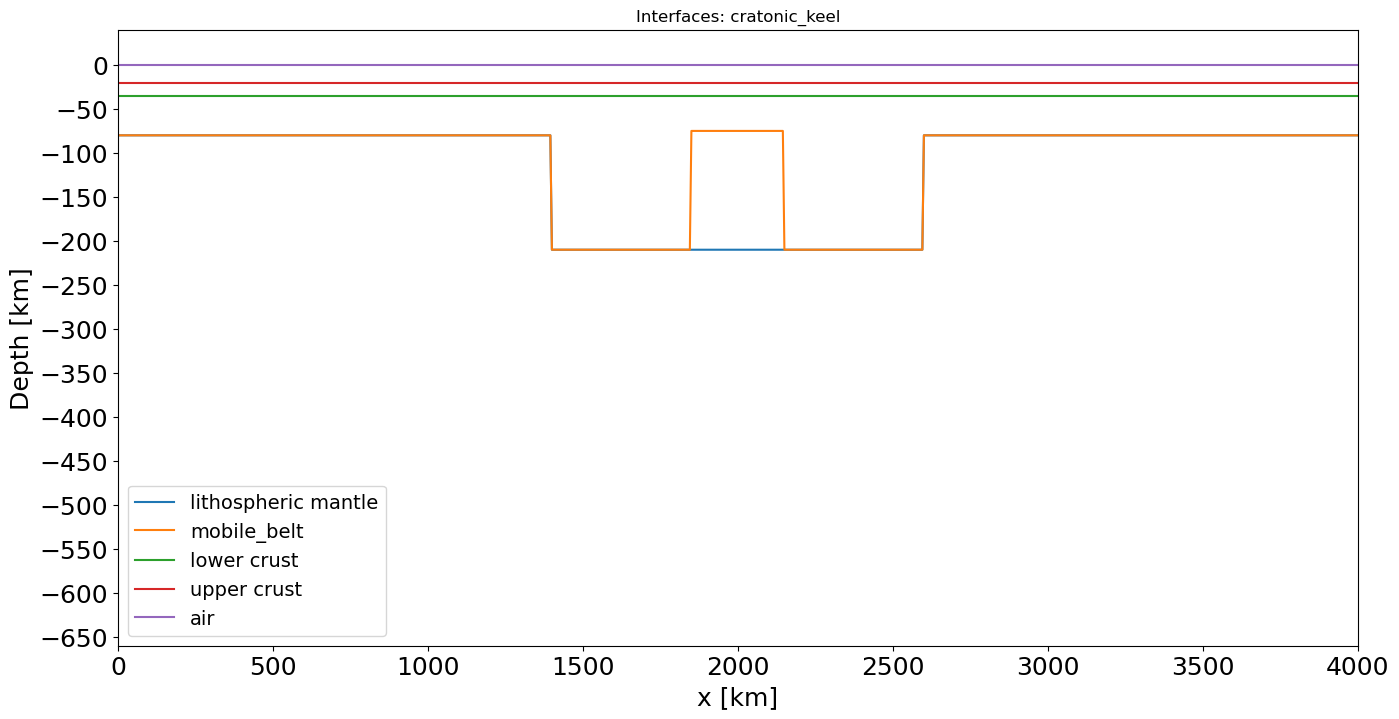

In [18]:
#Plot interfaces
fig, ax = plt.subplots(figsize=(16, 8))

for layer in layers[1::]:
    ax.plot(x / 1.0e3, (-layer.interface+air.base_depth) / 1e3, label=f"{layer.layer_label}")

ax.set_yticks(np.arange(-Lz / 1e3, 1 / 1e3, 50))
ax.set_xlim([0, Lx/1000])
ax.set_ylim([(-Lz+air.base_depth) / 1e3, 0+air.base_depth / 1e3])

ax.set_xlabel("x [km]")
ax.set_ylabel("Depth [km]")

ax.set_xlabel("x [km]", fontsize=label_size)
ax.set_ylabel("Depth [km]", fontsize=label_size)

ax.set_title("Interfaces: " + experiment)
ax.legend(loc='lower left', fontsize=label_size-4)

In [13]:
##################################################
# Save interfaces.txt to be used in Mandyoc code #
##################################################

#Build layer_properties according to the order of the stack_layers
rheological_symbols = ['C', 'rho', 'H', 'A', 'n', 'Q', 'V']
rheological_properties = ['effective_viscosity_scale_factor',
                          'density',
                          'radiogenic_heat_production',
                          'pre_exponential_constant',
                          'power_law_exponent',
                          'activation_energy',
                          'activation_volume']

to_save = []
for symbol, prop in zip(rheological_symbols, rheological_properties):
    to_save.append(f"{symbol} {' '.join([str(layer.__dict__[prop]) for layer in layers])}")


# for line in to_save:
#     print(line)

with open("interfaces.txt", "w") as f:

    for line in to_save:
        if len(line):
            f.write(f"{' '.join(line.split())}\n")

    # layer interfaces
    data = -1 * np.array(tuple(layer.interface for layer in layers[1::])).T
    np.savetxt(f, data, fmt="%.1f")

## 6. Create initial temperature field

### `Preset` option as `False`

If the `preset == False`, the initial temperature structure is depth dependent and is 0°C at the surface and 1300°C at the base of the lithosphere.
With these boundary conditions, the initial temperature structure in the interior of the lithosphere is given by the solution of the following equation:

$$ \kappa \frac{\partial^2 T(z)}{\partial z^2} + \frac{H(z)}{c_p} = 0$$

where $H(z)$ is the internal heat production of the different layers.

The sublithospheric temperature follows an adiabatic increase up to the bottom of the model:

$$T = T_p exp (g \alpha z ∕c_p) + \Delta T$$

Where $T_p$ is the potential temperature for the mantle, $g$ is the gravity aceletation, $\alpha$ is the volumetric expansion coefficient, $c_p$ is the specific heat capacity, $\Delta$ T is the increment in basal temperature.

For the experiments of LAB stability ou can increase the basal temperature by setting a value for `DeltaT`. For other experiments, `DeltaT = 0`

### `Preset` option as `True`
If the `preset == True` the temperature field is extracted from an external model used as Preliminary Model and interpolated in the new grid accordind to the `interp_method`:
- `'horizontal_mean'`: calculate the horizontal mean for each depth of the external temperature field and interpolate in the new mesh using `interp1d` from `scipy`.<br>


In [14]:
##############################################################################
# Initial temperature field
##############################################################################

if(preset == False):
    T = 1300 * (z - thickness_air) / (thickness_litho)  # Temperature
    # T = 1300 * (z - thickness_air) / (130*1.0E3)  # Temperature of 1300 isotherm bellow the lithosphere

    ccapacity = 1250*1.0 #937.5=75% #J/kg/K? #DEFAULT.
    # ccapacity = 1250*0.75 #937.5=75% #J/kg/K?
    # ccapacity = 750

    TP = 1262 #mantle potential temperature
    # TP = 1350
    # TP = 1400
    # TP = 1450

    Ta = (TP / np.exp(-10 * 3.28e-5 * (z - thickness_air) / ccapacity)) + DeltaT
    # Ta = 1262 / np.exp(-10 * 3.28e-5 * (z - thickness_air) / ccapacity)steady s

    T[T < 0.0] = 0.0
    cond1 = Ta<T #VICTOR
    T[T > Ta] = Ta[T > Ta] #apply the temperature of asthenosphere Ta where temperature T is greater than Ta, 

    # kappa = 0.75*1.0e-6 #thermal diffusivity
    kappa = 1.0e-6 #thermal diffusivity

    H = np.zeros_like(T)

    cond = (z >= thickness_air) & (z < thickness_upper_crust + thickness_air)  # upper crust
    H[cond] = upper_crust.radiogenic_heat_production

    cond = (z >= thickness_upper_crust + thickness_air) & (
        z < thickness_lower_crust + thickness_upper_crust + thickness_air
    )  # lower crust
    H[cond] = lower_crust.radiogenic_heat_production

    Taux = np.copy(T)
    t = 0
    dt = 5000
    dt_sec = dt * 365 * 24 * 3600
    # cond = (z > thickness_air + thickness_litho) | (T == 0)  # (T > 1300) | (T == 0) #OLD
    cond = cond1 | (T == 0)  # (T > 1300) | (T == 0) #VICTOR
    dz = Lz / (Nz - 1)
    
    while t < 500.0e6:
        T[1:-1] += (
            kappa * dt_sec * ((T[2:] + T[:-2] - 2 * T[1:-1]) / dz ** 2)
            + H[1:-1] * dt_sec / ccapacity
        )
        T[cond] = Taux[cond]
        t = t + dt
    
    T = np.ones_like(X) * T[:, None] #(Nz, Nx)

    print('shape T: ', np.shape(T))

    if(keel_adjust == True): #Making the base of cratonic keel cold as the base of the lithosphere (1300 oC)
        xcenter = Lx/2.0
    
        Datai = T

        Nx_aux = Nx
        Nz_aux = Nz
        Lx_aux = Lx
        Lz_aux = Lz

        x_aux = np.linspace(0, Lx_aux, Nx_aux)
        z_aux = np.linspace(Lz_aux, 0, Nz_aux)
        xx_aux, zz_aux  = np.meshgrid(x_aux, z_aux)
        
        datai_mean = calc_mean_temperaure_region(Datai, Nz_aux, xx_aux, 0, Lx_aux)

        #Making the temperature profile for the keel
        Tk_mean = np.copy(datai_mean)
        cond_mlit = (z_aux <= thickening+thickness_air) & (z_aux >= thickness_air + thickness_upper_crust + thickness_lower_crust)
                    
        T1 = datai_mean[cond_mlit][0] #bottom
        T0 = datai_mean[cond_mlit][-1] #top
        z1 = z_aux[cond_mlit][0]
        z0  = z_aux[cond_mlit][-1]

        # The temperature in the keel is linearly interpolated between the bottom and top of the keel
        Tk_mean[cond_mlit] = ((T1 - T0) / (z1 - z0)) * (z_aux[cond_mlit] - z0) + T0

        #interpolating the temperature field to the mesh of the model
        fk = interp1d(z_aux, Tk_mean)
        Tk_mean_interp = fk(z) #interpolated temperature profile for cratonic keel

        #dealing with <=0 values inherited from interpolation and setting to 0 values to the air layer
        Tk_mean_interp[Tk_mean_interp <= 1.0e-7] = 0.0 #dealing with <=0 values inherited from interpolation
        zcond = z <= 40.0e3
        Tk_mean_interp[zcond] = 0.0
    else:
        datai_mean = np.mean(T, axis=1) #simple horizontal mean for scenarios without cratonic keel

    for i in range(Nx): #Attributing the values of temperature field
        if(keel_adjust == True):
            if((x[i] >= xcenter - Lcraton/2.0 + shift_craton) & (x[i] <= xcenter + Lcraton/2.0 + shift_craton)): #keel region
                T.T[i, :] = Tk_mean_interp #must transpose to work

    # Save the initial temperature file
    # np.savetxt("input_temperature_0.txt", np.reshape(T, (Nx * Nz)), header="T1\nT2\nT3\nT4")

else:
    dz = Lz / (Nz - 1)

    # from_dataset = True
    from_dataset = False

    if(from_dataset == True):
        # print('entrei from dataset')
        # # local = True
        # local = False
        # if(local==True):
            # fpath = f"{machine_path}/{partial_path_to_preliminary_model}"
        # else:
        #     # print('entrei local false')
        #     external_media = 'Joao_Macedo'
        #     # external_media = 'Joao_Macedo'
        #     if(path[1] == 'home'):
                # fpath = f"{machine_path}/{external_media}{partial_path_to_preliminary_model}"
        #     elif(path[1] == 'Users'):
                # fpath = f'/Volumes/{external_media}{partial_path_to_preliminary_model}'

        #     elif(path[1] == 'media'):
                # fpath = f"{machine_path}/{external_media}{partial_path_to_preliminary_model}"
        #     elif(path[1] == 'Volumes'):
                # fpath = f'/Volumes/{external_media}{partial_path_to_preliminary_model}'

        fpath = f'{path_to_preliminary_model}'
        dataset = xr.open_dataset(f"{fpath}_output_temperature.nc")
        
        Nx_aux = int(dataset.nx)
        Nz_aux = int(dataset.nz)
        Lx_aux = float(dataset.lx)
        Lz_aux = float(dataset.lz)

        x_aux = np.linspace(0, Lx_aux, Nx_aux)
        z_aux = np.linspace(Lz_aux, 0, Nz_aux)
        xx_aux, zz_aux  = np.meshgrid(x_aux, z_aux)

        time = dataset.time[-1]
        Datai = dataset.temperature[-1].values.T
    else:
        # local = False
        # if(local==True):
            # fpath = f"{machine_path}/{partial_path_to_preliminary_model}"
        # else:
        #     # print('entrei local false')
        #     external_media = 'Joao_Macedo'
        #     # external_media = 'Joao_Macedo'
        #     if(path[1] == 'home'):
                # fpath = f"{machine_path}/{external_media}{partial_path_to_preliminary_model}"
        #     elif(path[1] == 'Users'):
                # fpath = f'/Volumes/{external_media}{partial_path_to_preliminary_model}'

        #     elif(path[1] == 'media'):
                # fpath = f"{machine_path}/{external_media}{partial_path_to_preliminary_model}"
        #     elif(path[1] == 'Volumes'):
                # fpath = f'/Volumes/{external_media}{partial_path_to_preliminary_model}'
        # fpath = f"{fpath}"

        fpath = f"{path_to_preliminary_model}"
        
        Nx_aux, Nz_aux, Lx_aux, Lz_aux = read_params(fpath)

        x_aux = np.linspace(0, Lx_aux, Nx_aux)
        z_aux = np.linspace(Lz_aux, 0, Nz_aux)
        xx_aux, zz_aux  = np.meshgrid(x_aux, z_aux)

        steps = sorted(glob.glob(fpath+"time_*.txt"), key=os.path.getmtime)
        step_final = int(steps[-1].split('/')[-1][5:-4]) #step of final thermal structure
        
        time_fname = fpath + 'time_' + str(step_final) + '.txt'
        time = np.loadtxt(time_fname, usecols=2, max_rows=1)

        Datai = read_data('temperature', step_final, Nz_aux, Nx_aux, fpath) #(read final thermal structure (Nz, Nx)
    

    #Setting procedure with external temperature field:
    #Using the horizontal mean of temperature from final step of used scenario (horizontal_mean)
    interp_method = 'horizontal_mean' #using interp1d
    
    if(interp_method == 'horizontal_mean'):
        if(keel_adjust == True): #Making the base of cratonic keel cold as the base of the lithosphere (1300 oC)
            xcenter = Lx/2.0

            datai_mean = calc_mean_temperaure_region(Datai, Nz_aux, xx_aux, 0, Lx_aux)

            #Making the temperature profile for the keel
            Tk_mean = np.copy(datai_mean)
            cond_mlit = (z_aux <= thickening+thickness_air) & (z_aux >= thickness_air + thickness_upper_crust + thickness_lower_crust)
                     
            T1 = datai_mean[cond_mlit][0] #bottom
            T0 = datai_mean[cond_mlit][-1] #top
            z1 = z_aux[cond_mlit][0]
            z0  = z_aux[cond_mlit][-1]

            # The temperature in the keel is linearly interpolated between the bottom and top of the keel
            Tk_mean[cond_mlit] = ((T1 - T0) / (z1 - z0)) * (z_aux[cond_mlit] - z0) + T0

            #interpolating the temperature field to the mesh of the model
            fk = interp1d(z_aux, Tk_mean)
            Tk_mean_interp = fk(z) #interpolated temperature profile for cratonic keel

            #dealing with <=0 values inherited from interpolation and setting to 0 values to the air layer
            Tk_mean_interp[Tk_mean_interp <= 1.0e-7] = 0.0 #dealing with <=0 values inherited from interpolation
            zcond = z <= 40.0e3
            Tk_mean_interp[zcond] = 0.0

        else:
            datai_mean = np.mean(Datai, axis=1) #simple horizontal mean for scenarios without cratonic keel

        f = interp1d(z_aux, datai_mean) #funcion to interpolate the temperature field
        datai_mean_interp = f(z) #applying the function to obtain the temperature field to the new mesh

        zcond = z <= 40.0e3
        datai_mean_interp[datai_mean_interp <= 1.0e-7] = 0.0 #dealing with <=0 values inherited from interpolation
        datai_mean_interp[zcond] = 0.0

        T = np.zeros((Nx, Nz)) #(Nx, Nz) = transpose of original shape (Nz, Nx)
        
        for i in range(Nx): #Attributing the values of temperature field
            if(keel_adjust == True):
                if((x[i] >= xcenter - Lcraton/2.0 + shift_craton) & (x[i] <= xcenter + Lcraton/2.0 + shift_craton)): #keel region
                    T[i, :] = Tk_mean_interp
                else:
                    T[i, :] = datai_mean_interp
            else:
                T[i, :] = datai_mean_interp

        T = T.T #(Nz,Nx): transpose T to plot below
        # print('shape T: ', np.shape(T))

    np.savetxt("input_temperature_0.txt", np.reshape(T, (Nx * Nz)), header="T1\nT2\nT3\nT4")


shape T:  (141, 801)


lithospheric mantle
mobile_belt
lower crust
upper crust
air


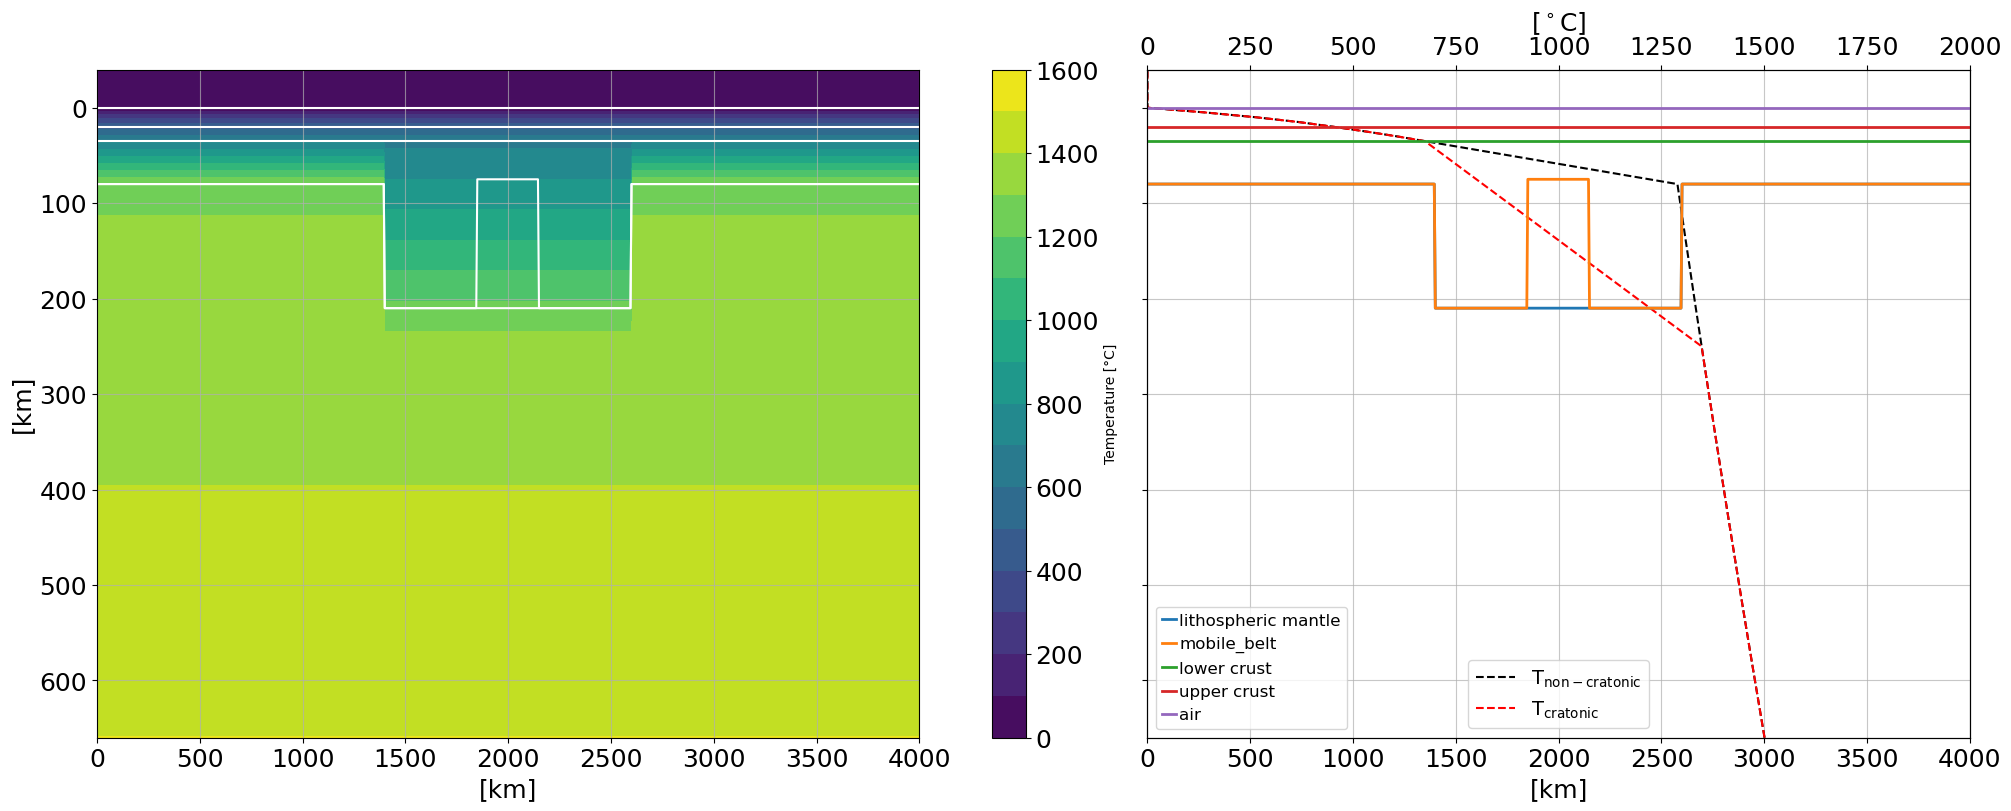

In [22]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(20, 8), sharey=True)

im = ax0.contourf(X / 1.0e3, (Z - thickness_air) / 1.0e3, T,
                  levels=np.arange(0, np.max(T) + 100, 100))
ax0.set_ylim((Lz - thickness_air) / 1.0e3, -thickness_air / 1000)
ax0.set_xlabel("km", fontsize=label_size)
ax0.set_ylabel("km", fontsize=label_size)
ax1.set_xlabel("$^\circ$C", fontsize=label_size)


if(keel_adjust==True):    
    idx = 0

    ax1.plot(T[:, idx], (z - thickness_air) / 1.0e3, "--k", label=r'T$_{\mathrm{non-cratonic}}$')
    ax1.plot(Tk_mean_interp, (z - thickness_air) / 1.0e3, '--', color='r', label=r'T$_{\mathrm{cratonic}}$')
    
    # ax1.plot(tfit, (z - thickness_air) / 1.0e3, '--', color='b', label=r'T$_{\mathrm{fit}}$')
else:
    ax1.plot(T[:, 0], (z - thickness_air) / 1.0e3, "--k", label=r'T$_{\mathrm{mean}}$')

T_xlim = 2000 #oC
code = 0

ax_aux = ax1.twiny()

for layer in layers[1::]:
    print(layer.layer_label)
    # print(label, "(size): ", np.size(layer))
    # ax1.plot(x/1.0E3, (-layer + thickness_air)/1.0E3, label=f"{label}")
    ax0.plot(x/1.0E3, (layer.interface - thickness_air)/1.0E3, color='xkcd:white')
    ax_aux.plot(x/1.0E3, (layer.interface - thickness_air)/1.0E3, label=f"{layer.layer_label}", lw=2)


ax0.set_ylim((Lz - thickness_air) / 1.0e3, -thickness_air / 1000)
ax0.set_xlabel("[km]", fontsize=label_size)
ax0.set_ylabel("[km]", fontsize=label_size)


ax1.set_xlabel("[$^\circ$C]", fontsize=label_size)
cbar = fig.colorbar(im, orientation='vertical', ax=ax0)
cbar.set_label("Temperature [°C]")

ax1.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
ax1.xaxis.set_label_position('top')
ax1.set_ylim((Lz - thickness_air) / 1.0e3, -thickness_air / 1000)
ax1.set_xlim(0, T_xlim)
ax0.grid(':k', alpha=0.7)
ax1.grid(':k', alpha=0.7)

ax_aux.tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)
ax_aux.xaxis.set_label_position('bottom')
ax_aux.set_xlabel('[km]', fontsize=label_size)
ax_aux.set_xlim(0, Lx/1000)
ax_aux.set_ylim((Lz - thickness_air) / 1.0e3, -thickness_air / 1000)

ax1.legend(loc='lower center', fontsize=14, ncol=1)
ax_aux.legend(loc='lower left', fontsize=12, ncol=1, handletextpad=0.2, handlelength=.8)

fig.savefig("initial_temperature_field.png")


## 7. Boundary condition - Velocity

The horizontal velocity field along the left and right borders of the domain presents two layers:
* Constant velocity with depth at $0 ≤ z < h_c$
* Linearly variable velocity with depth at $h_c ≤ z ≤ h_c + h_a$

where $h_c$ km is the thickness of the upper layer with constant velocity, corresponding to the lithosphere $h_{litho}$ km and part of the asthenosphere, and $h_a$ km corresponds to the remaining asthenospheric portion of the model until the bottom
of the model, where the horizontal velocity at the borders of the model varies linearly with depth.

Therefore, the sum $h_c + h_a$ represents the total thickness of the model without the “sticky air” layer.

In [23]:
if(velocity_from_ascii == True):

    if(ast_wind == True): #this case is for cratonic keel experiments presented in Silva et al. (2025)
        fac_air = 10.0e3

        vL = (0.5*velocity/100) / (365 * 24 * 3600)  # m/s

        h_v_const = thickness_litho + 20.0e3  #thickness with constant velocity 
        ha = Lz - thickness_air - h_v_const  # difference

        #Right side
        vR = 2 * vL * (h_v_const + fac_air + ha) / ha  # this is to ensure integral equals zero

        VX = np.zeros_like(X)
        cond = (Z > h_v_const + thickness_air) & (X == 0) #left side
        VX[cond] = vR * (Z[cond] - h_v_const - thickness_air) / ha

        cond = (Z > h_v_const + thickness_air) & (X == Lx) #right side
        VX[cond] = vR * (Z[cond] - h_v_const - thickness_air) / ha

        # cond = X == Lx #right side
        # VX[cond] += +2 * vL

        cond = Z <= thickness_air - fac_air
        VX[cond] = 0

        # print(np.sum(VX))

        v0 = VX[(X == 0)]
        vf = VX[(X == Lx)]
        sv0 = np.sum(v0[1:-1]) + (v0[0] + v0[-1]) / 2.0
        svf = np.sum(vf[1:-1]) + (vf[0] + vf[-1]) / 2.0
        # print(sv0, svf, svf - sv0)

        diff = (svf - sv0) * dz

        vv = -diff / Lx
        # print(vv, diff, svf, sv0, dz, Lx)

        VZ = np.zeros_like(X)

        cond = Z == 0
        VZ[cond] = vv
        #save bc to plot arraows in numerical setup
        vels_bc = np.array([v0, vf])
        vz0 = VZ[(z == 0)]

    else: #Rifting experiment with reference frame at the left side of the model (Silva et al., 2023)
        fac_air = 10.0e3

        vL = (0.5*velocity/100) / (365 * 24 * 3600)  # m/s

        h_v_const = thickness_litho + 20.0e3  #thickness with constant velocity 
        ha = Lz - thickness_air - h_v_const  # difference

        vR = 2 * vL * (h_v_const + fac_air + ha) / ha  # this is to ensure integral equals zero

        VX = np.zeros_like(X)
        cond = (Z > h_v_const + thickness_air) & (X == 0)
        VX[cond] = vR * (Z[cond] - h_v_const - thickness_air) / ha

        cond = (Z > h_v_const + thickness_air) & (X == Lx)
        VX[cond] = -vR * (Z[cond] - h_v_const - thickness_air) / ha

        cond = X == Lx
        VX[cond] += +2 * vL

        cond = Z <= thickness_air - fac_air
        VX[cond] = 0

        # print(np.sum(VX))

        v0 = VX[(X == 0)]
        vf = VX[(X == Lx)]
        sv0 = np.sum(v0[1:-1]) + (v0[0] + v0[-1]) / 2.0
        svf = np.sum(vf[1:-1]) + (vf[0] + vf[-1]) / 2.0
        # print(sv0, svf, svf - sv0)

        diff = (svf - sv0) * dz

        vv = -diff / Lx
        # print(vv, diff, svf, sv0, dz, Lx)

        VZ = np.zeros_like(X)

        cond = Z == 0
        VZ[cond] = vv
        #save bc to plot arraows in numerical setup
        vels_bc = np.array([v0, vf])
        vz0 = VZ[(z == 0)]

    np.savetxt("vel_bc.txt", vels_bc.T)
    np.savetxt("velz_bc.txt", vz0.T)
    # print(np.sum(v0))

    VVX = np.copy(np.reshape(VX, Nx * Nz))
    VVZ = np.copy(np.reshape(VZ, Nx * Nz))

    v = np.zeros((2, Nx * Nz))

    v[0, :] = VVX
    v[1, :] = VVZ

    v = np.reshape(v.T, (np.size(v)))

    # Create the initial velocity file
    np.savetxt("input_velocity_0.txt", v, header="v1\nv2\nv3\nv4")

In [24]:
# Plot veolocity
##############################################################################
if(velocity_from_ascii == True):
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(9, 9), constrained_layout=True, sharey=True)

    ax0.plot(VX[:, 0]*(365 * 24 * 3600), (z - thickness_air) / 1000, "k-", label="left side")
    ax1.plot(VZ[:, 0]*(365 * 24 * 3600), (z - thickness_air) / 1000, "k-", label="left side")

    ax0.plot(VX[:, -1]*(365 * 24 * 3600), (z - thickness_air) / 1000, "r-", label="right side")
    ax1.plot(VZ[:, -1]*(365 * 24 * 3600), (z - thickness_air) / 1000, "r-", label="right side")

    ax0.legend(loc='upper left', fontsize=14)
    ax1.legend(loc='upper right', fontsize=14)

    ax0_xlim = ax0.get_xlim()
    ax1_xlim = ax1.get_xlim()

    ax0.set_yticks(np.arange(0, Lz / 1000, 40))
    ax1.set_yticks(np.arange(0, Lz / 1000, 40))

    ax0.set_ylim([Lz / 1000 - thickness_air / 1000, -thickness_air / 1000])
    ax1.set_ylim([Lz / 1000 - thickness_air / 1000, -thickness_air / 1000])

    fig.suptitle(f"Velocity boundary conditions (v = {velocity} cm/yr)")
    # ax0.set_xlim([-8, 8])
    # ax1.set_xlim([-8, 8])
    # # ax0.set_xticks(np.arange(-8, 9, 4))
    # ax1.set_xticks(np.arange(-8, 9, 4))

    ax0.set_xlim([-0.05, 0.05])
    ax1.set_xlim([-0.05, 0.05])
    ax0.set_xticks(np.linspace(-0.05, 0.05, 5))
    ax1.set_xticks(np.linspace(-0.05, 0.05, 5))

    ax0.grid(':k', alpha=0.7)
    ax1.grid(':k', alpha=0.7)

    # ax0.set_xlabel("$10^{-10}$ (m/s)", fontsize=label_size)
    # ax1.set_xlabel("$10^{-10}$ (m/s)", fontsize=label_size)

    ax0.set_xlabel("cm/yr", fontsize=label_size)
    ax1.set_xlabel("cm/yr", fontsize=label_size)

    ax0.set_ylabel("Depth (km)", fontsize=label_size)

    ax0.set_title("Horizontal component of velocity")

    ax1.set_title("Vertical component of velocity")

    fig.savefig("velocity.png")

For experiments with variation in boundary condidtions of velocity field (e.g. Wilson Cycle), we need to set `variable_bcv == True` in Section 4 above to create a `scale_bcv.txt` file and specify:
- Number of instants that velocity fild must be reescaled (n)
- Time_instant_in_Myr scale_factor_of_velocity_field

Example:

`var_bcv = f""" <number_of_instants_to_reescale_velocity_field>`

                 <instant_0> <scale_factor_of_velocity_field_0>
                 ...
                 <instant_n> <scale_factor_of_velocity_field_n>
                 """

In [25]:
if(variable_bcv == True):
    if(experiment == 'wilson_cycle'):
        var_bcv = f""" 2
                    40.0 0.001
                    70.0 -1000.0

                    """
    elif(experiment == 'cratonic_keel'):
        if(ast_wind == True and intermitent_wind==True):
            var_bcv = f""" 24
                        40 -1.0
                        80 1.0
                        120 -1.0
                        160 1.0
                        200 -1.0
                        240 1.0
                        280 -1.0
                        320 1.0
                        360 -1.0
                        400 1.0
                        440 -1.0
                        480 1.0
                        520 -1.0
                        560 1.0
                        600 -1.0
                        640 1.0
                        680 -1.0
                        720 1.0
                        760 -1.0
                        800 1.0
                        840 -1.0
                        880 1.0
                        920 -1.0
                        960 1.0
                        """
    # Create the parameter file
    with open("scale_bcv.txt", "w") as f:
        for line in var_bcv.split("\n"):
            line = line.strip()
            if len(line):
                f.write(" ".join(line.split()) + "\n")

## 8. Surface process

Setting `sp_surface_processes == True` and `sp_surface_processes == True` in Section 4 above creates a `precipitation.txt` file. The procedure is the same adopted by Silva and Sacek (2022):

$$\dot e(x) = k_{\mathrm{sp}} e_f(x)\mathrm{\ \ for \ }t>10\mathrm{\ Myr,}$$

where, $k_{\mathrm{sp}}$ is the maximum denudation rate and $e_f$ is the spatial control of denudation, given by:


$$e_f(x) = \mathrm{exp}\left[-\frac{(x - x_c)^6}{x_{\sigma}^6}\right]\mathrm{.}$$

$x_{\sigma}$ controls the spatial extent of denudation from the center of the model at position $x = x_c$, and $t$ is time since the onset of the numerical simulation. Erosion acts only if the topographic surface is above sea level ($h > h_{\mathrm{sl}}$).

Setting `climate_change_from_ascii == True` in Section 4 above you can choose the instants to the action the surface process and the scale factor of the precipitation function by modifying `climate` as the example:

`climate = f""" <number_of_instants_to_reescale_surface_process>`

                 <instant_0> <scale_factor_of_surface_process_0>
                 ...
                 <instant_n> <scale_factor_of_surface_process_n>
                 """



In [26]:
if(sp_surface_processes == True):
    if(climate_change_from_ascii == True):
        #When climate effects will start to act - scaling to 1
        climate = f'''
                2
                0 0.0
                10 0.02
            '''

        with open('climate.txt', 'w') as f:
            for line in climate.split('\n'):
                line = line.strip()
                if len(line):
                    f.write(' '.join(line.split()) + '\n')

    if(precipitation_profile_from_ascii ==True):
        #Creating precipitation profile

        # prec = 0.0008*np.exp(-(x-Lx/2)**6/(Lx/8)**6) #original
        # prec = 0.0008*np.exp(-(x-Lx/2)**6/(Lx/(8*2))**6) #100 km
        prec = 0.0008*np.exp(-(x-Lx/2)**6/(Lx/(8*4))**6) #50 km
        np.savetxt("precipitation.txt", prec, fmt="%.8f")
        
        
        fig, ax = plt.subplots(1,1, figsize=(10, 6), constrained_layout=True)
        ax.set_xlim([0, Lx/1.0E3])
        ax.set_ylim([0, np.max(prec)])
        ax.set_xlabel("[km]", fontsize=label_size)
        ax.set_ylabel("Precipitation", fontsize=label_size)
        ax.plot(x/1000,prec)
        ax.grid(':k', alpha=0.7)

        figname='precipitation_profile.png'
        fig.savefig(figname)

## 9. Create the parameter file - param.txt

In [28]:
params = f"""
nx = {Nx}
nz = {Nz}
lx = {Lx}
lz = {Lz}
# Simulation options
multigrid                           = 1             # ok -> soon to be on the command line only
solver                              = direct        # default is direct [direct/iterative]
denok                               = {denok}       # default is 1.0E-4
particles_per_element               = {particles_per_element}          # default is 81
particles_perturb_factor            = 0.7           # default is 0.5 [values are between 0 and 1]
rtol                                = 1.0e-7        # the absolute size of the residual norm (relevant only for iterative methods), default is 1.0E-5
RK4                                 = Euler         # default is Euler [Euler/Runge-Kutta]
Xi_min                              = 1.0e-7       # default is 1.0E-14
random_initial_strain               = 0.2           # default is 0.0
pressure_const                      = -1.0          # default is -1.0 (not used) - useful only in horizontal 2D models
initial_dynamic_range               = True         # default is False [True/False]
periodic_boundary                   = False         # default is False [True/False]
high_kappa_in_asthenosphere         = {high_kappa_in_asthenosphere}         # default is False [True/False]
K_fluvial                           = 2.0e-7        # default is 2.0E-7
m_fluvial                           = 1.0           # default is 1.0
sea_level                           = 0.0           # default is 0.0
basal_heat                          = 0.0          # default is -1.0
# Surface processes
sp_surface_tracking                 = {sp_surface_tracking}         # default is False [True/False]
sp_surface_processes                = {sp_surface_processes}         # default is False [True/False]
sp_dt                               = 1.0e5        # default is 0.0
sp_d_c                              = 1.0          # default is 0.0
plot_sediment                       = False         # default is False [True/False]
a2l                                 = True          # default is True [True/False]
free_surface_stab                   = True          # default is True [True/False]
theta_FSSA                          = 0.5           # default is 0.5 (only relevant when free_surface_stab = True)
# Time constrains
step_max                            = 800000          # Maximum time-step of the simulation
time_max                            = {time_max}  #1.0e9     # Maximum time of the simulation [years]
dt_max                              = {dt_max}      # Maximum time between steps of the simulation [years]
step_print                          = {step_print} #500            # Make file every <step_print>
sub_division_time_step              = 0.5           # default is 1.0
initial_print_step                  = 0             # default is 0
initial_print_max_time              = 1.0e6         # default is 1.0E6 [years]
# Viscosity
viscosity_reference                 = 1.0e26        # Reference viscosity [Pa.s]
viscosity_max                       = 1.0e25        # Maximum viscosity [Pa.s]
viscosity_min                       = 1.0e18        # Minimum viscosity [Pa.s]
viscosity_per_element               = constant      # default is variable [constant/variable]
viscosity_mean_method               = arithmetic      # default is harmonic [harmonic/arithmetic]
viscosity_dependence                = pressure      # default is depth [pressure/depth]
# External ASCII inputs/outputs
interfaces_from_ascii               = True          # default is False [True/False]
n_interfaces                        = {len(layers)}           # Number of interfaces int the interfaces.txt file
variable_bcv                        = {variable_bcv} #False         # default is False [True/False]
temperature_from_ascii              = True         # default is False [True/False]
velocity_from_ascii                 = {velocity_from_ascii} #False      # default is False [True/False]
binary_output                       = False         # default is False [True/False]
sticky_blanket_air                  = True         # default is False [True/False]
precipitation_profile_from_ascii    = {precipitation_profile_from_ascii}         # default is False [True/False]
climate_change_from_ascii           = {climate_change_from_ascii}         # default is False [True/False]
print_step_files                    = {print_step_files}          # default is True [True/False]
checkered                           = {checkered}         # Print one element in the print_step_files (default is False [True/False])
sp_mode                             = 5             # default is 1 [0/1/2]
geoq                                = on            # ok
geoq_fac                            = 100.0           # ok
# Physical parameters
temperature_difference              = 1500.         # ok
thermal_expansion_coefficient       = 3.28e-5       # ok
thermal_diffusivity_coefficient     = 1.0e-6 #0.75e-6       #default is 1.0e-6        # ok
gravity_acceleration                = 10.0          # ok
density_mantle                      = 3300.         # ok
external_heat                       = 0.0e-12       # ok
heat_capacity                       = 1250          # ok #default is 1250
non_linear_method                   = on            # ok
adiabatic_component                 = on            # ok
radiogenic_component                = on            # ok
magmatism                           = on            # ok
# Velocity boundary conditions
top_normal_velocity                 = fixed         # ok
top_tangential_velocity             = free          # ok
bot_normal_velocity                 = fixed         # ok
bot_tangential_velocity             = free          # ok
left_normal_velocity                = {left_normal_velocity}         # ok
left_tangential_velocity            = {left_tangential_velocity}          # ok
right_normal_velocity               = {right_normal_velocity}         # ok
right_tangential_velocity           = {right_tangential_velocity}         # ok
surface_velocity                    = 0.0e-2        # ok
multi_velocity                      = False         # default is False [True/False]
# Temperature boundary conditions
top_temperature                     = {top_temperature}         # ok
bot_temperature                     = {bot_temperature}         # ok
left_temperature                    = {left_temperature}         # ok
right_temperature                   = {right_temperature}         # ok
rheology_model                      = 19             # ok
T_initial                           = 3             # ok
"""

# Create the parameter file
with open("param.txt", "w") as f:
    for line in params.split("\n"):
        line = line.strip()
        if len(line):
            f.write(" ".join(line.split()) + "\n")

## 10. Create a shell script to run the model 

Run the cell bellow to create a shell script that to run this example

In [14]:
dirname = '${PWD##*/}'
if(experiment == 'rifting' or experiment == 'wilson_cycle'):
    mandyoc_options = '-seed 0,2 -strain_seed 0.0,1.0'
else:
    mandyoc_options = '-seed 0 -strain_seed 0.0'


run = f'''
        #!/bin/bash
        MPI_PATH=$HOME/opt/petsc/arch-label-optimized/bin
        MANDYOC_PATH=$HOME/opt/mandyoc/bin/mandyoc
        NUMBER_OF_CORES={ncores}
        MANDYOC_OPTIONS={mandyoc_options}
        touch FD.out
        $MPI_PATH/mpiexec -n $NUMBER_OF_CORES $MANDYOC_PATH $MANDYOC_OPTIONS | tee FD.out

        DIRNAME={dirname}

        zip $DIRNAME.zip interfaces.txt param.txt input*_0.txt vel_bc.txt velz_bc.txt run*.sh
        zip -u $DIRNAME.zip bc_velocity_*.txt
        zip -u $DIRNAME.zip density_*.txt
        zip -u $DIRNAME.zip heat_*.txt
        zip -u $DIRNAME.zip pressure_*.txt
        zip -u $DIRNAME.zip sp_surface_global_*.txt
        zip -u $DIRNAME.zip strain_*.txt
        zip -u $DIRNAME.zip temperature_*.txt
        zip -u $DIRNAME.zip time_*.txt
        zip -u $DIRNAME.zip velocity_*.txt
        zip -u $DIRNAME.zip viscosity_*.txt
        zip -u $DIRNAME.zip scale_bcv.txt
        zip -u $DIRNAME.zip step*.txt
        zip -u $DIRNAME.zip Phi*.txt
        zip -u $DIRNAME.zip dPhi*.txt
        zip -u $DIRNAME.zip X_depletion*.txt
        zip -u $DIRNAME.zip *.log

        #rm *.log
        rm vel_bc*
        rm velz*
        rm bc_velocity*
        rm velocity*
        rm step*
        rm temperature*
        rm density*
        rm viscosity*
        rm heat*
        rm strain_*
        rm time*
        rm pressure_*
        rm sp_surface_global*
        rm scale_bcv.txt
        rm Phi*
        rm dPhi*
        rm X_depletion*
        
    '''
with open('run.sh', 'w') as f:
    for line in run.split('\n'):
        line = line.strip()
        if len(line):
            f.write(' '.join(line.split()) + '\n')

# 11. Gathering and saving the important model information

We will construct a list called `scenario_infos` to create a .txt file containing the most import information about the numerical experiment as:
- Experiment: type of geodynamic experiment
- Viscosity scale factors (C) of the layers
- Domain parameters
- Layers thickness
- And others

In [29]:
scenario_infos = ['MODEL INFORMATION:']
scenario_infos.append(' ')
scenario_infos.append(f'Saving input files at: {path[-1]}')
scenario_infos.append(f'Experiment: {experiments[experiment]}')
scenario_infos.append(f'Chosen number of cores:  {ncores}')


scenario_infos.append(' ')
scenario_infos.append('Scale factors (C):')
for layer in layers:
    scenario_infos.append(f'C {layer.layer_label}: {layer.effective_viscosity_scale_factor}')

scenario_infos.append(' ')
scenario_infos.append(f'Preset of initial temperature field: {preset}')

if(experiment == "cratonic_keel"):
    scenario_infos.append(f'Force cold cratonic keel: {keel_adjust}')
    scenario_infos.append(f'Shift of craton: {shift_craton/1.0e3} km')
    scenario_infos.append(f'Craton with Mobile Belt: {mobile_belt}')

scenario_infos.append(' ')
scenario_infos.append(f'High kappa in asthenosphere: {high_kappa_in_asthenosphere}')

scenario_infos.append(' ')
scenario_infos.append(f'Surface process: {sp_surface_processes}')

scenario_infos.append(' ')
scenario_infos.append(f'Velocity field {velocity_from_ascii}')
if(velocity_from_ascii):
    scenario_infos.append(f'\tVelocity: {velocity} cm/yr')
    scenario_infos.append(f'\tVariable velocity field: {variable_bcv}')

scenario_infos.append(' ')
scenario_infos.append(f'Climate change: {climate_change_from_ascii}')

scenario_infos.append(' ')
scenario_infos.append('Domain parameters:')
scenario_infos.append(f'\tLx: {Lx*1.0e-3} km')
scenario_infos.append(f'\tLz: {Lz*1.0e-3} km')
scenario_infos.append(f'\tNx: {Nx}')
scenario_infos.append(f'\tNz: {Nz}')
scenario_infos.append(f'\tResolution dx x dz: {int(1.0e-3*Lx/(Nx-1))} x {int(1.0e-3*Lz/(Nz-1))} km2')

scenario_infos.append(' ')
scenario_infos.append('Layers thickness:')
scenario_infos.append(f'\tH air: {thickness_air*1.0e-3} km')
scenario_infos.append(f'\tH upper crust: {thickness_upper_crust*1.0e-3} km')
scenario_infos.append(f'\tH lower crust: {thickness_lower_crust*1.0e-3} km')
scenario_infos.append(f'\tH mantle lithosphere: {(thickness_litho - thickness_upper_crust - thickness_lower_crust)*1.0e-3} km')
scenario_infos.append(f'\tH lithosphere: {thickness_litho*1.0e-3} km')
if(experiment == 'craton_keel'):
    scenario_infos.append(f'\tH cratonic lithosphere: {thickening} km')
    scenario_infos.append(f"\tKeel shape: Lcraton x Hcraton = {Lcraton/1.0e3} x {thickening/1.0e3} km2")
    if(mobile_belt):
        scenario_infos.append(f"\tMobile Belt shape:  Lmb x Hmb = {Lmb/1.0e3} x {(thickening-thinning)/1.0e3} km2")
        scenario_infos.append(f"\tShift in mobile belt: {shift_mb/1.0e3} km")
if(seed_in_litho):
    scenario_infos.append(f'\tH seed: {thickness_seed*1.0e-3} km')

scenario_infos.append(' ')
scenario_infos.append('Initial temperature field setup:')
if(preset == False):
    scenario_infos.append(f'\tSelection in preset: {selection_in_preset}')
    scenario_infos.append(f'\tUse horizontal mean of temperature from preset in lithosphere: {mean_litho}')
    scenario_infos.append(f'\tIncrease in mantle basal temperature (Ta): {DeltaT} oC')
    scenario_infos.append(f'\tAssumed mantle Potential Temperature: {TP} oC')
    if(experiment == "cratonic_keel"):
        scenario_infos.append(f'\tAdjust to cold cratonic keel: {keel_adjust}')
else:
    scenario_infos.append(f'\tPath to external scenario used for build initial temperature field: {fpath}')
    if(from_dataset):
        scenario_infos.append(f'\tUsing xarray dataset')
    else:
        scenario_infos.append(f'\tUsing ascii file')
    scenario_infos.append(f'\tSelection in preset: {selection_in_preset}')
    scenario_infos.append(f'\tUse horizontal mean of temperature from preset in lithosphere: {mean_litho}')
    scenario_infos.append(f'\tInterpolation method: {interp_method}')

#Save scenario infos
np.savetxt('infos_'+path[-1] + '.txt', scenario_infos, fmt="%s")
##########################################################################################################################

print(f'Experiment: {experiments[experiment]}')
print(f'Chosen number of cores: {ncores}')

print(' ')
print('Scale factors (C):')
for layer in layers:
    print(f'C {layer.layer_label}: {layer.effective_viscosity_scale_factor}')

print(' ')
print(f'High kappa in asthenosphere: {high_kappa_in_asthenosphere}')

print(' ')
print(f'Surface process: {sp_surface_processes}')

print(' ')
print(f'Velocity field: {velocity_from_ascii}')
if(velocity_from_ascii):
    print(f'\tVelocity: {velocity} cm/yr')
    print(f'\tVariable velocity field: {variable_bcv}')

print(' ')
print(f'Climate change: {climate_change_from_ascii}')

print(' ')
print('Domain parameters:')
print(f'\tLx: {Lx*1.0e-3} km')
print(f'\tLz: {Lz*1.0e-3} km')
print(f'\tNx: {Nx}')
print(f'\tNz: {Nz}')
print(f'\tResolution dx x dz {1.0e-3*Lx/(Nx-1)} x {1.0e-3*Lz/(Nz-1)} km2')

print(' ')
print('Layers thickness:')
print(f'\tH air: {thickness_air*1.0e-3} km')
print(f'\tH upper crust: {thickness_upper_crust*1.0e-3} km')
print(f'\tH lower crust: {thickness_lower_crust*1.0e-3} km')
print(f'\tH mantle lithosphere: {(thickness_litho - thickness_upper_crust - thickness_lower_crust)*1.0e-3} km')

if(experiment == 'craton_keel'):
    print(f'\tH cratonic lithosphere: {thickening} km')
    print(f'\tKeel shape: Lcraton x Hcraton = {Lcraton/1.0e3} x {thickening/1.0e3} km2')

    if(mobile_belt):
        print(f'\tMobile Belt shape:  Lmb x Hmb = {Lmb/1.0e3} x {(thickening-thinning)/1.0e3} km2')
        print(f'\tShift in mobile belt: {shift_mb/1.0e3} km')
print(f'\tH lithosphere: {thickness_litho*1.0e-3} km')

if(seed_in_litho):
    print(f'\tH seed: {thickness_seed*1.0e-3} km')

print(' ')
print('Initial temperature field setup:')
print(f'\tPreset of initial temperature field: {preset}')

if(experiment == "cratonic_keel"):
    print(f'\tForce cold cratonic keel: {keel_adjust}')
    print(f'\tShift of craton: {shift_craton/1.0e3} km')
    print(f'\tCraton with Mobile Belt: {mobile_belt}')

if(preset == False):
    print(f'\tIncrease in mantle basal temperature (Ta): {DeltaT} oC')
    print(f'\tAssumed mantle Potential Temperature: {TP} oC')

    if(experiment == "cratonic_keel"):
        print(f'\tAdjust to cold cratonic keel: {keel_adjust}')
else:
    print(f'\tPath to external scenario used for build initial temperature field: {fpath}')

    if(from_dataset):
        print(f'\tUsing xarray dataset')
    else:
        print(f'\tUsing ascii file')

    print(f'\tSelection in preset: {selection_in_preset}')
    print(f'\tUse horizontal mean of temperature from preset in lithosphere: {mean_litho}')
    print(f'\tInterpolation method: {interp_method}')

Experiment: Cratonic Keel
Chosen number of cores: 20
 
Scale factors (C):
C asthenosphere: 1.0
C lithospheric mantle: 1.0
C mobile_belt: 1.0
C lower crust: 1.0
C upper crust: 1.0
C air: 1.0
 
High kappa in asthenosphere: False
 
Surface process: False
 
Velocity field: False
 
Climate change: False
 
Domain parameters:
	Lx: 4000.0 km
	Lz: 700.0 km
	Nx: 801
	Nz: 141
	Resolution dx x dz 5.0 x 5.0 km2
 
Layers thickness:
	H air: 40.0 km
	H upper crust: 20.0 km
	H lower crust: 15.0 km
	H mantle lithosphere: 45.0 km
	H lithosphere: 80.0 km
 
Initial temperature field setup:
	Preset of initial temperature field: False
	Force cold cratonic keel: True
	Shift of craton: 0.0 km
	Craton with Mobile Belt: True
	Increase in mantle basal temperature (Ta): 0 oC
	Assumed mantle Potential Temperature: 1262 oC
	Adjust to cold cratonic keel: True


## 12. References
Brune S., Heine C., Pérez-Gussinyé M., Sobolev S. V., Rift migration explains continental margin asymmetry and crustal hyper-extension,
Nature communications, 2014, vol. 5, p. 1.

Gerya T. V., Yuen D. A., Characteristics-based marker-in-cell method with conservative finite-differences schemes for modeling geological flows with strongly variable transport properties, Physics of the Earth and Planetary Interiors, 2003a, vol. 140, p. 293

Huismans R. S., Beaumont C., Symmetric and asymmetric lithospheric extension: Relative effects of frictional-plastic and viscous strain softening, Journal of Geophysical Research: Solid Earth, 2003, vol. 108

Salazar‐Mora, C. A., Huismans, R. S., Fossen, H., & Egydio‐Silva, M. (2018). The Wilson cycle and effects of tectonic structural inheritance on rifted passive margin formation. Tectonics, 37(9), 3085-3101.

Silva, J. P. M., Sacek, V., & da Silva, R. M. (2023). The influence of lithospheric rheology and surface processes on the preservation of escarpments at rifted margins. Tectonophysics, 851, 229769.

Silva, J. P. M., Sacek, V., Ganade, C. E., & Manatschal, G. (2025). Rheological and topographic implications of thermal insulation created by supercontinents. Earth and Planetary Science Letters, 652, 119201.